SVM Accuracy: 0.8571428571428571
[[46  3]
 [10 32]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        49
           1       0.91      0.76      0.83        42

    accuracy                           0.86        91
   macro avg       0.87      0.85      0.85        91
weighted avg       0.86      0.86      0.86        91

LR Accuracy: 0.8791208791208791
[[45  4]
 [ 7 35]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        49
           1       0.90      0.83      0.86        42

    accuracy                           0.88        91
   macro avg       0.88      0.88      0.88        91
weighted avg       0.88      0.88      0.88        91

Fusion Accuracy=0.8791 (p=0.05, q=0.95)
Fusion Accuracy=0.8791 (p=0.10, q=0.90)
Fusion Accuracy=0.8791 (p=0.15, q=0.85)
Fusion Accuracy=0.8791 (p=0.20, q=0.80)
Fusion Accuracy=0.8462 (p=0.25, q=0.75)
Fusion Accuracy=0.8462 (p=0.30, q=0.70)
Fus

/Users/rishimane/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


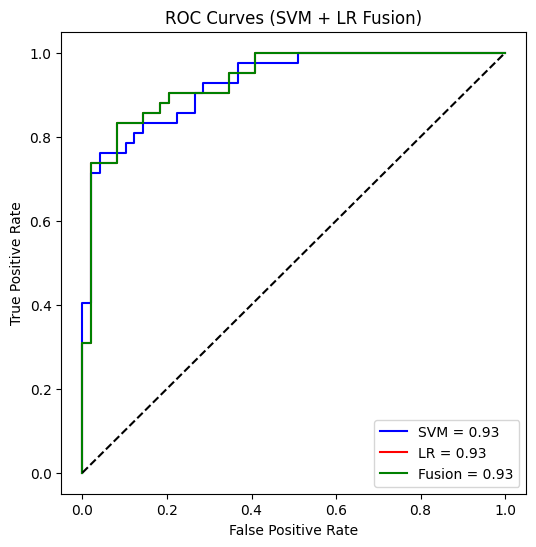

In [3]:
# ==============================
# Binary Fusion Model (SVM + LR)
# ==============================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
dataset = pd.read_csv("./binary classification.csv")

# Split features (0-12) and target (13th column)
X = dataset.iloc[:, 0:13].values
y = dataset.iloc[:, 13].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42
)


# ------------------------------
# Train SVM
# ------------------------------
from sklearn.svm import SVC
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train)
X_test_svm = scaler.transform(X_test)

svm_model = SVC(probability=True, C=1, gamma=0.01, random_state=42)
svm_model.fit(X_train_svm, y_train)

y_pred_svm = svm_model.predict(X_test_svm)
proba_svm = svm_model.predict_proba(X_test_svm)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

fpr_svm, tpr_svm, _ = roc_curve(y_test, proba_svm[:,1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

# ------------------------------
# Train Logistic Regression
# ------------------------------
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(C=1, solver="lbfgs", max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)
proba_lr = lr_model.predict_proba(X_test)

print("LR Accuracy:", accuracy_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

fpr_lr, tpr_lr, _ = roc_curve(y_test, proba_lr[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

# ------------------------------
# Weighted Fusion
# ------------------------------
best_acc = 0
best_p = None

for p in np.arange(0.05, 1.0, 0.05):
    q = 1 - p
    mixed = proba_svm[:,1]*p + proba_lr[:,1]*q
    rounded_mixed = (mixed >= 0.5).astype(int)
    acc = accuracy_score(y_test, rounded_mixed)
    if acc > best_acc:
        best_acc, best_p = acc, p
    print(f"Fusion Accuracy={acc:.4f} (p={p:.2f}, q={q:.2f})")

print("\nBest Fusion Accuracy:", best_acc, "at p=", best_p, "q=", 1-best_p)

# Final Fusion Confusion Matrix
p = best_p
q = 1 - p
mixed = proba_svm[:,1]*p + proba_lr[:,1]*q
rounded_mixed = (mixed >= 0.5).astype(int)

print("Fusion Confusion Matrix:\n", confusion_matrix(y_test, rounded_mixed))
print(classification_report(y_test, rounded_mixed))

fpr_fusion, tpr_fusion, _ = roc_curve(y_test, mixed)
roc_auc_fusion = auc(fpr_fusion, tpr_fusion)

# ------------------------------
# Plot ROC Curves
# ------------------------------
plt.figure(figsize=(6,6))
plt.title("ROC Curves (SVM + LR Fusion)")
plt.plot(fpr_svm, tpr_svm, 'b', label=f'SVM = {roc_auc_svm:.2f}')
plt.plot(fpr_lr, tpr_lr, 'r', label=f'LR = {roc_auc_lr:.2f}')
plt.plot(fpr_fusion, tpr_fusion, 'g', label=f'Fusion = {roc_auc_fusion:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.legend(loc="lower right")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()
